In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import plotly.express as px
%matplotlib inline

## Rosbank ML Competition

Ссылка на соревнование: https://boosters.pro/champ_15

Росбанк – часть ведущей международной финансовой группы Societe Generale, банк включен ЦБ РФ в число 11 системно значимых кредитных организаций России. Инновации неотъемлемый процесс работы Росбанка, поэтому активно развивается направленный анализа больших данных.

- Данные

Датасет, который содержит историю транзакций клиентов за 3 месяца льготного использования банковского продукта

- Задача

Задача бинарной классификации – прогноз оттока клиентов

Колонка cl_id содержит вутренний id клиента. Для каждого уникальнго cl_id следует предсказать продолжит ли клиент пользоваться продуктом (target_flag). Значение 0 соответствует отказу, а значение 1 соответствует продолжению использования

In [3]:
test_df = pd.read_csv(r'E:\ds3-spring-2018\kaggle\rosssss\test_rosbank.csv')
test_df

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category
0,01/04/2017,2,5814,NaN,810,18APR17:00:00:00,153.00,POS
1,01/03/2017,2,5812,NaN,810,10MAR17:00:00:00,388.08,POS
2,01/02/2017,2,5691,NaN,810,21FEB17:00:00:00,999.00,POS
3,01/04/2017,2,5814,NaN,810,26APR17:00:00:00,90.00,POS
4,01/04/2017,2,5814,NaN,810,08APR17:00:00:00,130.00,POS
...,...,...,...,...,...,...,...,...
518371,01/04/2017,10135,5074,type1,810,17APR17:00:00:00,6133.60,POS
518372,01/03/2017,10135,5912,type1,810,10MAR17:00:00:00,394.50,POS
518373,01/05/2017,10135,5541,type1,810,01MAY17:00:00:00,1813.50,POS
518374,01/03/2017,10135,5912,type1,810,16MAR17:00:00:00,569.30,POS


In [4]:
raw_df = pd.read_csv(r'E:\ds3-spring-2018\kaggle\rosssss\rossbank.csv')
raw_df.head(5)
# target_sum - можно выкинуть, переменная участвует в другой задаче

,PERIOD,cl_id,MCC,channel_type,currency,TRDATETIME,amount,trx_category,target_flag,target_sum
0,01/10/2017,0,5200,NaN,810,21OCT17:00:00:00,5023.0,POS,0,0.0
1,01/10/2017,0,6011,NaN,810,12OCT17:12:24:07,20000.0,DEPOSIT,0,0.0
2,01/12/2017,0,5921,NaN,810,05DEC17:00:00:00,767.0,POS,0,0.0
3,01/10/2017,0,5411,NaN,810,21OCT17:00:00:00,2031.0,POS,0,0.0
4,01/10/2017,0,6012,NaN,810,24OCT17:13:14:24,36562.0,C2C_OUT,0,0.0


In [5]:
raw_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 490513 entries, 0 to 490512
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   PERIOD        490513 non-null  object 
 1   cl_id         490513 non-null  int64  
 2   MCC           490513 non-null  int64  
 3   channel_type  487603 non-null  object 
 4   currency      490513 non-null  int64  
 5   TRDATETIME    490513 non-null  object 
 6   amount        490513 non-null  float64
 7   trx_category  490513 non-null  object 
 8   target_flag   490513 non-null  int64  
 9   target_sum    490513 non-null  float64
dtypes: float64(2), int64(4), object(4)
memory usage: 37.4+ MB


In [6]:
print("Total clients: ", len(raw_df.cl_id.unique()))

Total clients:  5000


Всего 5000 клиентов, случайным образом возьмем 1000 клиентов для тестирования

In [7]:
cl_ids_test = np.random.choice(raw_df.cl_id.unique(), size=1000, replace=False)
cl_ids_test_set = set(cl_ids_test)

In [8]:
# create transactions dataset for train
transactions_train = raw_df[~raw_df.cl_id.isin(cl_ids_test)].copy()   # то есть , то что не в списке cl_ids_test
print("Total transactions in train dataset: ", len(transactions_train))
# create transactions dataset for test
transactions_test = raw_df[raw_df.cl_id.isin(cl_ids_test)].copy()    # то что  в списке cl_ids_test
print("Total transactions in test dataset: ", len(transactions_test))

Total transactions in train dataset:  394529
Total transactions in test dataset:  95984


## Домашняя работа

1. Наборы данных вида Transactions (несколько транзакций на одного клиента) трансформировать в таблицу, где cl_id будут уникальными (соответственно 4000 строк в train и 1000 строк в test
2. Для каждого cl_id будет уникальное целевое событие target_flag, а также уникальный канал привлечения клиента channel_type (клиент привлекается лишь однажды и с самого начала его записи присваивается значение канала привлечения)
3. При агрегации (*pandas.DataFrame.groupby*) по cl_id (или по связке cl_id, channel_type, target_flag) необходимо создавать производные фичи, идеи для таких фичей могут быть следующими:

    - общая сумма транзакций по каждой из trx_category
    - общая сумма транзакции по основным вылютам (напр. выделить рубли, доллары и евро - предположительно, это будут самые крупные категории)
    - общая сумма транзакций по категориям MCC кодов (например, выбрать основные/популярные MCC коды). ВНИМАНИ! Некоторые MCC коды из train могут быть не представлены в test. Про MCC коды в целом: http://www.banki.ru/wikibank/mcc-kod/; Справочник MCC кодов: https://mcc-codes.ru/code; Про некоторые категории кэшбека Росбанка: https://mcc-codes.ru/card/rosbank-sverkh-plus;
    - возможные агрегации по времени суток и дням недели - траты в выходные (праздники) или будни, в ночное время или в рабочее и т.д.
3. **Обязательная часть**: провести первичный анализ данных - посмотреть распределения признаков, выделить самые популярные MCC, помотреть активность клиентов по дням недели/времени, какие категории транзакции (trx_category) наиболее популярны и т.д. Получить инсайты, которые в дальнейшем помогут вам правильно подготовить фичи
4. **Обязательная часть**: на большом количестве фичей применить Lasso регрессию и посмотреть, какие переменные получают 0 в качестве коэффициентов
5. **Обязательная часть**: на фичах из MCC кодов применить PCA и посмотреть, какие фичи получаются и что они могут объяснять (для этого посмотреть на коэффициенты в *sklearn.decomposition.pca.components_* после построения главных компонент)
6. **Обязательная часть**: с отобранными фичами и полученными компонентами обучить модель (тип алгоритма на свой вкус, можно начать с линейной) и померить качество на локальном тестовом наборе данных (локальная валидация), который создается в этом ноутбуке. Сравнить качество модели до добавления компонент/после добавления/только на главных компонентах. **Метрика оценки качества - ROC AUC**(https://en.wikipedia.org/wiki/Receiver_operating_characteristic)
8. **Дополнительная часть**: поучаствовать в соревновании - загрузить предсказания на https://boosters.pro/champ_15. Для этого необходимо использовать все данные из файла rosbank_train.csv, на них делать feature engineering и обучениеб затем делать предсказания для клиентов из файла rosbank_test.csv, предварительно создав фичи по аналогии с train.
9. Задания принимаются в виде ноутбука с кодом/картинками выполненной обязательной части + указанием места в leaderboard при решении дополнительной

При возникновении вопросов и для отправки домашнего задания - egsachko@gmail.com или http://fb.com/sachkoe
    

pip install nbformat в начале нужно для плотли

## Разберемся с MCC

#### Найдем уникальные значения MCC групп, и расписать какие из кодов в какую группу входят.

In [9]:
mcc_cod=pd.read_excel(r'E:\ds3-spring-2018\kaggle\rosssss\Spravochnik_MCC_Cod.xlsx')
mcc_cod=mcc_cod.drop(labels=[0])
mcc_cod=mcc_cod.drop(columns=['Unnamed: 1','Unnamed: 3','Unnamed: 4','Unnamed: 5','Unnamed: 6','Unnamed: 7','Unnamed: 8','Unnamed: 9','Unnamed: 10'])
mcc_cod.rename(columns={'Unnamed: 2':'Count'},inplace=True)

график распределения MCC кодов 

In [10]:
fig = px.funnel_area( names=mcc_cod['Count'].unique(), values=mcc_cod['Count'].value_counts())
fig.show()

посмотрим какими типами MCC пользовались клиенты которые остались 

In [11]:
# выделим тот датафрейм в котором только оставшиеся клиенты
mcc_1=raw_df['MCC'].loc[raw_df['target_flag']==1]
mcc=mcc_1.copy(deep=True)
count_mcc=pd.DataFrame(mcc_1.value_counts())
count_mcc['code']=count_mcc.index
count_mcc.rename(columns={'MCC':'amount'},inplace=True)
count_mcc['code']=count_mcc.code.astype(str)

In [12]:
fig=px.bar(count_mcc,x='code',y='amount')
fig.show()

видно,что основная часть сосредоточена на первых 10 значениях.  


In [13]:
count_mcc=count_mcc.loc[count_mcc['amount']>5000]
fig=px.bar(count_mcc,x='code',y='amount')
fig.show()

In [14]:
count_mcc.index

Int64Index([5411, 6011, 5814, 5812, 5499, 5541, 5912, 5999, 5921, 6012], dtype='int64')

Определим категории MCC кодов 

In [15]:
uniq=mcc_cod['Count'].unique()

In [16]:
mcc_group={}
for i in uniq:
    code=[mcc_cod['Справочник МСС-кодов'][mcc_cod['Count']==f'{i}']]
    mcc_group[f'{i}']=code


## Посмотрим на распределения кол-ва денег по категориям транзакций

In [17]:
trx_cat=raw_df['trx_category'].value_counts()
currency_cat=raw_df['currency'].value_counts()

In [18]:
amount_trx=raw_df.groupby(['trx_category']).agg({'amount':'sum'})
amount_trx=amount_trx.reset_index()
fig=px.bar(amount_trx,x=amount_trx.trx_category,y=amount_trx.amount,width=1000, height=600)
fig.show()

данные используем чтобы создадать сводную таблицу в которой представим кол-во потраченной суммы от кода валюты и типа транзакции и выведем графики

In [19]:
currency=raw_df['currency'].value_counts() 
currency=currency.loc[currency>500].index.to_list() 
# создали список самых часто используемых валют и потом отсортировали в новый фрейм данные
# также учитывали и самые популярные категории транзакций 
curr_df=raw_df.loc[raw_df['currency'].isin(currency) & raw_df['trx_category'].isin(['POS','DEPOSIT','WD_ATM_ROS','WD_ATM_PARTNER'])]


In [20]:
for i in currency:
    # сводная таблица агрегированная нами
    # пересоздавать h обязательно , а то она читает плохо после первого цикла
    h=curr_df.groupby(['currency','trx_category']).agg({'amount':'sum'})
    h=h.reset_index()
    h=h.loc[h.currency==i]
    fig=px.bar(h,x=h.trx_category,y=h.amount,title=f'{i}',width=800, height=400)
    fig.show()

график показывает сколько потратили в каждой валюте и  категории транзакций кол-во денег. В итоге можно некоторвые выбросить, тк слишком малые суммы.  
в основнеом пользовались рублем , евро в транзакции 'POS', долларом в транзакции 'POS' вот их мы и будем использовать как идни из признаков.

## Теперь выделим дни недели по которым совершались операции

In [21]:
# напишем функцию, преобразующую дату в нужный формат
from datetime import datetime
def change_date(date):
    curr_date=datetime.strptime(date, '%d/%m/%Y')
    return curr_date.strftime('%Y-%m-%d')

# создадим новую переменную , к которой применим функцию замены даты
period_new=curr_df[['PERIOD']].copy(deep=True)
period_new['PERIOD_NEW']=period_new.PERIOD.apply(change_date)
# в столбце PERIOD_NEW время записано как YYYY-MM-DD
# в столбце PERIOD время записано как DD/MM/YYYY

In [22]:
period_new['PERIOD_NEW'] = pd.to_datetime(period_new['PERIOD_NEW'], errors='coerce')

In [23]:
# создаем в новые столбцы, которые мы агрегируем из значений даты
period_new['Y']=period_new['PERIOD_NEW'].dt.year
period_new['M']=period_new['PERIOD_NEW'].dt.month
period_new['D']=period_new['PERIOD_NEW'].dt.day
period_new['target']=curr_df['target_flag']

In [24]:
date_frame=pd.DataFrame(period_new.copy(deep=True))

Выделим клиентов которые продолжили пользоваться банком. Посмотрим как дата влияет на целевой показатель

In [25]:
p_new=period_new.loc[period_new['target']==1]

p_new['target'].value_counts()

1    300226
Name: target, dtype: int64

In [26]:
def count_n(i):
    '''Функция считает кол-во категорий в Serias'''
    from collections import Counter
    current=Counter(i)
    return pd.DataFrame(current, index=['amount']).transpose()

In [27]:
count_year=count_n(p_new['Y'])
fig=px.bar(
    x=count_year.index,
    y=count_year['amount'],
    labels = {'x': 'The Year', 'y': 'amount'},
    title="Количесво оставшихся клиентов в каждый год",
    )
fig.show()

Видно из графика, что больше всего клиентов продолжило пользоваться , которые в 2017 году совершали опепрации.
Около 260 тысяч операций было совершено за 2017.  
Тогда можно рассмотреть, в каком месяце тогда сосредоточены люди продолжающие пользоваться услугами банка

In [28]:

count_month=count_n(p_new['M'].loc[p_new['Y']==2017])
fig=px.bar(
    x=count_month.index,
    y=count_month['amount'],
    labels = {'x': 'The month', 'y': 'amount'},
    title="Количесво оставшихся клиентов в 2017 год",
    )
fig.show()

В основном операции приходятся на лето и конец весны. используем эти данные для дальнейшего создания фич

In [29]:
new_date=period_new['PERIOD_NEW']
new_date = pd.to_datetime(new_date).dt.dayofweek
# добавим необходимую форматированную дату к нашему фрейму
curr_df=curr_df.join(new_date)

# избавимся от старого
curr_df.drop(['PERIOD'],axis=1,inplace=True)

In [30]:
m=period_new['M'].to_numpy() 
for i in range(0,len(m)):
    if m[i] in [6,7,8,]:
        # 1 значит , что операция совершена ночью
        m[i]=1
    else:
        # 0 значит опреация совершена днем
        m[i]=0
m=pd.DataFrame(m,columns=['summer'])
curr_df=curr_df.join(m['summer'])


## Теперь выделим время сутое и постараемся провести аналитику , зависит ли ночью или днем совершались покупки

In [31]:
import re
# С помощью регулярных выражений вытягиваем из столбца TRDATETIME информаци. о времени
time=[]
list_time=curr_df.TRDATETIME.to_list()
for i in list_time:
    patern=re.findall('(00|[0-9]|1[0-9]|2[0-3]):([0-9]|[0-5][0-9]):([0-9]|[0-5][0-9])$',i)
    time.extend(patern)
# преобразуем данные во фрейм
time=pd.DataFrame(time,columns=['hour','minute','second'])
#curr_df=curr_df.join(time['hour'])
t=time['hour'].to_numpy() 
# я специально пребразовал в ndarray тк он дает огромный выйгрыш по времени
# ссылка на статью 
# https://medium.com/nuances-of-programming/эффективное-итерирование-по-строкам-в-pandas-dataframe-43aa7d2588cb


In [32]:
# преобразуем значения в удобный формат
for i in range(0,len(t)):
    if t[i]=='00':
        # 1 значит , что операция совершена ночью
        t[i]=1
    else:
        # 0 значит опреация совершена днем
        t[i]=0
t=pd.DataFrame(t,columns=['night'])

In [33]:
from collections import Counter
cnt=Counter(time['hour'])
cnt_hour= pd.DataFrame(cnt, index=[0]).transpose()
fig=px.bar(cnt_hour, labels=dict(index="hour",))
fig.show()

Видно , что большинство операций совершалось в 12 часов ночи. Причем на несколько порядков больше чем других значений. поэтому выделим как отдельную фичу кол-во совершенных операций в 00 часов

In [34]:
curr_df=curr_df.join(t['night'])


## Создадим сводную таблицу по нашим данным

In [35]:
curr_df.drop('TRDATETIME',axis=1,inplace=True)

In [36]:
curr_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 462281 entries, 0 to 490512
Data columns (total 11 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   cl_id         462281 non-null  int64  
 1   MCC           462281 non-null  int64  
 2   channel_type  459516 non-null  object 
 3   currency      462281 non-null  int64  
 4   amount        462281 non-null  float64
 5   trx_category  462281 non-null  object 
 6   target_flag   462281 non-null  int64  
 7   target_sum    462281 non-null  float64
 8   PERIOD_NEW    462281 non-null  int64  
 9   summer        435439 non-null  float64
 10  night         435439 non-null  object 
dtypes: float64(3), int64(5), object(3)
memory usage: 58.4+ MB


на основе наших предположений агрегируем таблицу

Самые часто встречающиеся MCC среди оставшихсф клиентов имеют код  
5411, 6011, 5814, 5812, 5499, 5541, 5912   
почти все относятся к категории Retail Purchase  
выберем только эти значения для агрегации

In [37]:
mcc_list=[5411, 6011, 5814, 5812, 5499, 5541, 5912]

В основном пользовались только рублем и самые объемные по колличеству оборота денег категории транзакций  
'POS' , 'WD_ATM_ROS' 

In [38]:
currency_list=[810,]
trx_category_list=['POS','WD_ATM_ROS','DEPOSIT']

In [39]:
night_list=[1]

Тк 1 и 2 канал привлечения самые популярые и информативные, то используем только их

In [40]:
channel_list=['type1','type2']

In [41]:
df_88=curr_df.loc[(curr_df.MCC.isin(mcc_list))
                  &(curr_df.channel_type.isin(channel_list))
                  &(curr_df.trx_category.isin(trx_category_list))
                  &(curr_df.currency.isin(currency_list)),
                  ]
df_cp=df_88.copy(deep=True)
df_88.drop(columns=['amount','target_flag','target_sum','PERIOD_NEW','summer','night'],axis=1,inplace=True)
df_88

C:\Users\Kirilll\AppData\Local\Temp\ipykernel_13648\1100863255.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,cl_id,MCC,channel_type,currency,trx_category
12973,269,5411,type2,810,POS
12976,272,5541,type2,810,POS
12977,272,6011,type2,810,WD_ATM_ROS
12978,269,5814,type2,810,POS
12979,269,5411,type2,810,POS
...,...,...,...,...,...
490507,10186,5411,type1,810,POS
490508,10176,6011,type1,810,WD_ATM_ROS
490509,10171,5411,type1,810,POS
490510,10167,5541,type1,810,POS


In [42]:
df_88.currency.value_counts()

810    281400
Name: currency, dtype: int64

In [43]:
df_model_agg=df_88.groupby(['cl_id','channel_type', 'MCC', 'trx_category',]).agg({'cl_id':'count'})
df_model_agg=df_model_agg.rename(columns={'cl_id':'trx_count'})
#df_model_agg
df_model_agg.unstack(level=[1,2,3]).reset_index()


cl_id trx_count                                                 \
channel_type            type2                                                  
MCC                      5411  5541 5812  5814 5912  5499       6011           
trx_category              POS   POS  POS   POS  POS   POS WD_ATM_ROS DEPOSIT   
0               269      48.0   3.0  9.0  54.0  7.0   NaN        NaN     NaN   
1               272      15.0   6.0  NaN   1.0  NaN  44.0       17.0     NaN   
2               273      64.0   NaN  4.0  58.0  4.0   NaN        NaN     NaN   
3               274      25.0  13.0  6.0   3.0  7.0  63.0        NaN     NaN   
4               277      11.0   NaN  7.0   NaN  1.0   NaN        NaN     NaN   
...             ...       ...   ...  ...   ...  ...   ...        ...     ...   
4641          10210       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4642          10212       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4643          10213       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4644          10214       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   
4645          10215       NaN   NaN  NaN   NaN  NaN   NaN        NaN     NaN   

                                                                   
channel_type type1                                                 
MCC           5411  5499 5541  5814  5912 5812    6011             
trx_category   POS   POS  POS   POS   POS  POS DEPOSIT WD_ATM_ROS  
0              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
1              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
2              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
3              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
4              NaN   NaN  NaN   NaN   NaN  NaN     NaN        NaN  
...            ...   ...  ...   ...   ...  ...     ...        ...  
4641          31.0  22.0  6.0  15.0   1.0  4.0     2.0        3.0  
4642           NaN   NaN  NaN   NaN   NaN  NaN     7.0        NaN  
4643          29.0   1.0  3.0   7.0   1.0  8.0     8.0        NaN  
4644          24.0   6.0  2.0   2.0  15.0  2.0     NaN        NaN  
4645           9.0   NaN  NaN   1.0   NaN  2.0     4.0        NaN  

[4646 rows x 17 columns]

In [44]:
df_model_agg.head(20)

trx_count
cl_id channel_type MCC  trx_category           
269   type2        5411 POS                  48
                   5541 POS                   3
                   5812 POS                   9
                   5814 POS                  54
                   5912 POS                   7
272   type2        5411 POS                  15
                   5499 POS                  44
                   5541 POS                   6
                   5814 POS                   1
                   6011 WD_ATM_ROS           17
273   type2        5411 POS                  64
                   5812 POS                   4
                   5814 POS                  58
                   5912 POS                   4
274   type2        5411 POS                  25
                   5499 POS                  63
                   5541 POS                  13
                   5812 POS                   6
                   5814 POS                   3
                   5912 POS                   7

In [45]:
def pvt_table(two_cols_df):
    agg_vals=two_cols_df.groupby(['cl_id',two_cols_df.columns[1]]).agg({'cl_id':'count'}).rename(columns={'cl_id':'cnt_trx'}).reset_index()
    pvt_new=agg_vals.pivot_table(
                        index='cl_id',
                        columns=two_cols_df.columns[1],
                        values='cnt_trx',
                        aggfunc='sum')
    return pvt_new


In [46]:

for i in range(0,len(df_88.columns)-1):
    if i==0:
        vt_final=pvt_table(df_88[['cl_id',df_88.columns[i+1]]])
    else:
        vt_final=vt_final.merge(pvt_table(df_88[['cl_id',df_88.columns[i+1]]]),on='cl_id', )
       

In [47]:
vt_final.head()

,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS
cl_id,,,,,,,,,,,,,
269,48.0,NaN,3.0,9.0,54.0,7.0,NaN,NaN,121.0,121,NaN,121.0,NaN
272,15.0,44.0,6.0,NaN,1.0,NaN,17.0,NaN,83.0,83,NaN,66.0,17.0
273,64.0,NaN,NaN,4.0,58.0,4.0,NaN,NaN,130.0,130,NaN,130.0,NaN
274,25.0,63.0,13.0,6.0,3.0,7.0,NaN,NaN,117.0,117,NaN,117.0,NaN
277,11.0,NaN,NaN,7.0,NaN,1.0,NaN,NaN,19.0,19,NaN,19.0,NaN


In [48]:
agg_target=df_cp.groupby(['cl_id','target_flag']).agg({'target_flag':'count'})

In [49]:
trg=[]
for i in range(0,len(vt_final)):
    t=agg_target.index[i][1]
    trg.append(t)
trg=pd.DataFrame(trg,columns=['target'])
pvt_final=vt_final.join(trg,)
pvt_final

,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS,target
cl_id,,,,,,,,,,,,,,
269,48.0,NaN,3.0,9.0,54.0,7.0,NaN,NaN,121.0,121,NaN,121.0,NaN,1.0
272,15.0,44.0,6.0,NaN,1.0,NaN,17.0,NaN,83.0,83,NaN,66.0,17.0,0.0
273,64.0,NaN,NaN,4.0,58.0,4.0,NaN,NaN,130.0,130,NaN,130.0,NaN,1.0
274,25.0,63.0,13.0,6.0,3.0,7.0,NaN,NaN,117.0,117,NaN,117.0,NaN,1.0
277,11.0,NaN,NaN,7.0,NaN,1.0,NaN,NaN,19.0,19,NaN,19.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10210,31.0,22.0,6.0,4.0,15.0,1.0,5.0,84.0,NaN,84,2.0,79.0,3.0,NaN
10212,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,7,7.0,NaN,NaN,NaN
10213,29.0,1.0,3.0,8.0,7.0,1.0,8.0,57.0,NaN,57,8.0,49.0,NaN,NaN


In [50]:
pvt_final.reset_index()

,cl_id,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS,target
0,269,48.0,NaN,3.0,9.0,54.0,7.0,NaN,NaN,121.0,121,NaN,121.0,NaN,1.0
1,272,15.0,44.0,6.0,NaN,1.0,NaN,17.0,NaN,83.0,83,NaN,66.0,17.0,0.0
2,273,64.0,NaN,NaN,4.0,58.0,4.0,NaN,NaN,130.0,130,NaN,130.0,NaN,1.0
3,274,25.0,63.0,13.0,6.0,3.0,7.0,NaN,NaN,117.0,117,NaN,117.0,NaN,1.0
4,277,11.0,NaN,NaN,7.0,NaN,1.0,NaN,NaN,19.0,19,NaN,19.0,NaN,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,10210,31.0,22.0,6.0,4.0,15.0,1.0,5.0,84.0,NaN,84,2.0,79.0,3.0,NaN
4642,10212,NaN,NaN,NaN,NaN,NaN,NaN,7.0,7.0,NaN,7,7.0,NaN,NaN,NaN
4643,10213,29.0,1.0,3.0,8.0,7.0,1.0,8.0,57.0,NaN,57,8.0,49.0,NaN,NaN
4644,10214,24.0,6.0,2.0,2.0,2.0,15.0,NaN,51.0,NaN,51,NaN,51.0,NaN,NaN


## Применим метод главных компонент к столбцу MCC

Сначала преобразуем данные для обработки и проведем стандартизацию значений

In [51]:
from sklearn import preprocessing  
label=preprocessing.LabelEncoder()

label_df=pvt_final.copy()

# Удалим не нужные столбцы
label_df=label_df.drop(['target',], axis=1)
label_df=label_df.fillna(0)
label_df

,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS
cl_id,,,,,,,,,,,,,
269,48.0,0.0,3.0,9.0,54.0,7.0,0.0,0.0,121.0,121,0.0,121.0,0.0
272,15.0,44.0,6.0,0.0,1.0,0.0,17.0,0.0,83.0,83,0.0,66.0,17.0
273,64.0,0.0,0.0,4.0,58.0,4.0,0.0,0.0,130.0,130,0.0,130.0,0.0
274,25.0,63.0,13.0,6.0,3.0,7.0,0.0,0.0,117.0,117,0.0,117.0,0.0
277,11.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,19.0,19,0.0,19.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
10210,31.0,22.0,6.0,4.0,15.0,1.0,5.0,84.0,0.0,84,2.0,79.0,3.0
10212,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,0.0,7,7.0,0.0,0.0
10213,29.0,1.0,3.0,8.0,7.0,1.0,8.0,57.0,0.0,57,8.0,49.0,0.0


In [52]:
from sklearn import preprocessing  
from sklearn.preprocessing import StandardScaler

st_scale=StandardScaler()

df_scaled=st_scale.fit_transform(label_df,pvt_final['target'])
df_scaled=pd.DataFrame(df_scaled)


c:\Users\Kirilll\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.

c:\Users\Kirilll\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\utils\validation.py:1858: FutureWarning:

Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.



In [53]:
df_scaled=df_scaled.dropna()
df_scaled

,0,1,2,3,4,5,6,7,8,9,10,11,12
0,0.854214,-0.500996,-0.151859,0.278646,2.902974,0.560031,-0.779546,-0.777033,2.227890,1.162910,-0.582210,1.371804,-0.503169
1,-0.375113,3.431109,0.320493,-0.531880,-0.475699,-0.691057,0.942984,-0.777033,1.370974,0.431663,-0.582210,0.264297,1.637026
2,1.450252,-0.500996,-0.624210,-0.171646,3.157969,0.023851,-0.779546,-0.777033,2.430844,1.336100,-0.582210,1.553032,-0.503169
3,-0.002590,5.129064,1.422647,0.008471,-0.348202,0.560031,-0.779546,-0.777033,2.137688,1.085937,-0.582210,1.291258,-0.503169
4,-0.524123,-0.500996,-0.624210,0.098529,-0.539448,-0.512330,-0.779546,-0.777033,-0.072253,-0.799912,-0.582210,-0.682118,-0.503169
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4641,0.220924,1.465057,0.320493,-0.171646,0.416781,-0.512330,-0.272920,0.924314,-0.500710,0.450906,-0.267223,0.526071,-0.125487
4642,-0.933899,-0.500996,-0.624210,-0.531880,-0.539448,-0.691057,-0.070269,-0.635254,-0.500710,-1.030833,0.520243,-1.064711,-0.503169
4643,0.146420,-0.411630,-0.151859,0.188588,-0.093208,-0.512330,0.031056,0.377452,-0.500710,-0.068665,0.677736,-0.078023,-0.503169
4644,-0.039842,0.035200,-0.309309,-0.351763,-0.411951,1.989846,-0.779546,0.255927,-0.500710,-0.184125,-0.582210,-0.037750,-0.503169


In [54]:
from sklearn.decomposition import PCA 
 
pca = PCA(n_components=7) 
pca.fit_transform(df_scaled) 
mcc_test = pca.transform(df_scaled) 

In [55]:
print(sum(pca.explained_variance_ratio_) )
print(pca.explained_variance_ratio_)

0.9128900713339221
[0.37880108 0.14652167 0.13606053 0.07592477 0.06157482 0.05882425
 0.05518296]


видно что MCC объясняет 91% данных

## Регуляризация

может я ее рано сделал

Для начала избавимся от ненужных столбцов и закодируем данные

In [56]:
pvt_final=pvt_final.fillna(0)
pvt_final

,5411,5499,5541,5812,5814,5912,6011,type1,type2,810,DEPOSIT,POS,WD_ATM_ROS,target
cl_id,,,,,,,,,,,,,,
269,48.0,0.0,3.0,9.0,54.0,7.0,0.0,0.0,121.0,121,0.0,121.0,0.0,1.0
272,15.0,44.0,6.0,0.0,1.0,0.0,17.0,0.0,83.0,83,0.0,66.0,17.0,0.0
273,64.0,0.0,0.0,4.0,58.0,4.0,0.0,0.0,130.0,130,0.0,130.0,0.0,1.0
274,25.0,63.0,13.0,6.0,3.0,7.0,0.0,0.0,117.0,117,0.0,117.0,0.0,1.0
277,11.0,0.0,0.0,7.0,0.0,1.0,0.0,0.0,19.0,19,0.0,19.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10210,31.0,22.0,6.0,4.0,15.0,1.0,5.0,84.0,0.0,84,2.0,79.0,3.0,0.0
10212,0.0,0.0,0.0,0.0,0.0,0.0,7.0,7.0,0.0,7,7.0,0.0,0.0,0.0
10213,29.0,1.0,3.0,8.0,7.0,1.0,8.0,57.0,0.0,57,8.0,49.0,0.0,0.0


In [57]:
from sklearn import preprocessing  
label=preprocessing.LabelEncoder()

curr_df=curr_df.dropna()
label_df=curr_df.copy()

# Выберем категориальные значения из curr_df
cat_feature=list(curr_df.dtypes[curr_df.dtypes==object].index)

# применим LabelEncoder
for i in cat_feature:
    label_df[f'{i}']=label.fit_transform(curr_df[f'{i}'])

# Также закодируем и MCC и currency
label_df['MCC']=label.fit_transform(label_df['MCC'])
label_df['currency']=label.fit_transform(label_df['currency'])
label_target=label_df['target_flag']
# Удалим не нужные столбцы
label_df=label_df.drop(['target_sum','target_flag',], axis=1)
label_df

,cl_id,MCC,channel_type,currency,amount,trx_category,PERIOD_NEW,summer,night
2911,50,144,4,0,2373.0,1,4,0.0,1
2912,50,182,4,0,5955.0,1,4,1.0,1
2913,50,166,4,0,5599.0,1,5,1.0,1
2914,50,177,4,0,29600.0,1,5,0.0,1
2915,50,182,4,0,1038.0,1,4,0.0,1
...,...,...,...,...,...,...,...,...,...
462276,9598,144,0,0,435.0,1,4,0.0,0
462277,9598,144,0,0,95.5,1,1,1.0,1
462278,9603,226,0,0,809.0,1,6,0.0,1
462279,9598,182,0,0,99.0,1,1,1.0,1


In [58]:
from sklearn.preprocessing import StandardScaler
scaler=StandardScaler()

mod_df=scaler.fit_transform(label_df)

mod_df=pd.DataFrame(mod_df)

In [59]:
mod_df


,0,1,2,3,4,5,6,7,8
0,-1.622441,-0.682233,5.158791,-0.123077,-0.139455,-0.128239,0.485613,-0.678291,0.336026
1,-1.622441,0.191544,5.158791,-0.123077,0.053512,-0.128239,0.485613,1.474293,0.336026
2,-1.622441,-0.176362,5.158791,-0.123077,0.034334,-0.128239,1.016638,1.474293,0.336026
3,-1.622441,0.076573,5.158791,-0.123077,1.327302,-0.128239,1.016638,-0.678291,0.336026
4,-1.622441,0.191544,5.158791,-0.123077,-0.211374,-0.128239,0.485613,-0.678291,0.336026
...,...,...,...,...,...,...,...,...,...
432669,1.813692,-0.682233,-0.683258,-0.123077,-0.243858,-0.128239,0.485613,-0.678291,-2.975962
432670,1.813692,-0.682233,-0.683258,-0.123077,-0.262147,-0.128239,-1.107462,1.474293,0.336026
432671,1.815491,1.203286,-0.683258,-0.123077,-0.223710,-0.128239,1.547663,-0.678291,0.336026
432672,1.813692,0.191544,-0.683258,-0.123077,-0.261959,-0.128239,-1.107462,1.474293,0.336026


In [60]:
from sklearn import linear_model

l1 = linear_model.Lasso(alpha=0.01,max_iter=10)
l1.fit(mod_df,label_target )

print(l1.coef_)
print(l1.intercept_)
print()


[-0.19335634  0.         -0.         -0.         -0.00074746  0.00203867
  0.          0.0004301   0.        ]
0.6630511655426488



зануленные коэфиценты отбрасываются. Как видно имеет больше 0,1 только параметр 'channel_type'

## Обучение модели

воспользуемся методом XGBoost

In [61]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve , roc_auc_score, auc
y = pvt_final['target'].copy()
pvt_final.drop(['target'], axis=1, inplace=True)
X_train, X_test, y_train, y_test = train_test_split(pvt_final, y, test_size=0.3, random_state=50)


In [62]:

clf_xgb=xgb.XGBClassifier(max_depth=5)
clf_xgb.fit(X_train,y_train)
y_pred_xgb_test=clf_xgb.predict_proba(X_test)[:,1]
y_pred_xgb_train=clf_xgb.predict_proba(X_train)[:,1]
print('Train',roc_auc_score(y_train,y_pred_xgb_train))
print('Test',roc_auc_score(y_test,y_pred_xgb_test))



Train 0.9927032000760725
Test 0.8370967421053679


Train:
ROC AUC: 0.9927
Test:
ROC AUC: 0.8371


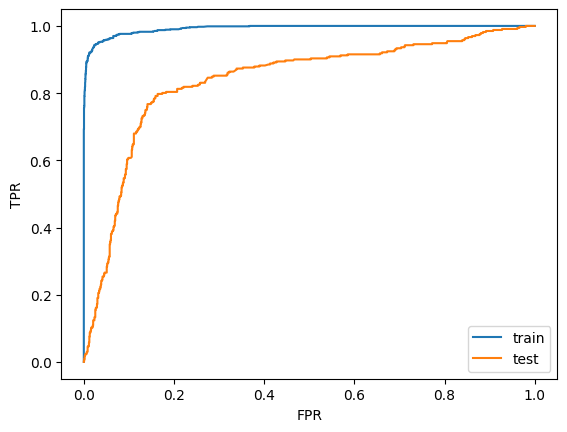

In [63]:
def calc_auc(y, y_pred, plot_label='', prin=True):
    fpr, tpr, _ = roc_curve(y, y_pred)
    auc_val = auc(fpr, tpr)
    if prin:
        print('ROC AUC: {0:.4f}'.format(auc_val))
    if plot_label:
        plt.plot(fpr, tpr, label=plot_label)
        plt.xlabel('FPR')
        plt.ylabel('TPR')
    return auc_val

print('Train:')
calc_auc(y_train, y_pred_xgb_train, 'train')
print('Test:')
calc_auc(y_test, y_pred_xgb_test, 'test')
plt.legend();

это разобрать надо  
https://translated.turbopages.org/proxy_u/en-ru.ru.fac085b4-64a895ba-16ef5c60-74722d776562/https/github.com/hyperopt/hyperopt/wiki/FMin

In [64]:
from hyperopt import hp, fmin, tpe, STATUS_OK, Trials


params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}

#функция, которую будем МИНИМИЗИРОВАТЬ
def score(params):
    params['max_depth'] = int(params['max_depth'])
    params['n_jobs'] = -1
    print("Training with params : ", params)
    clf = xgb.XGBClassifier(**params)
    clf.fit(X_train, y_train)
    y_pred_xgb_test = clf.predict_proba(X_test)[:, 1]
    auc = calc_auc(y_test, y_pred_xgb_test, prin=False)
    result = {'loss': 1-auc, 'status': STATUS_OK}
    print('TEST ROC AUC: {0:.4f}'.format(auc))
    return result



space = {'max_depth' : hp.quniform('max_depth', 1, 10, 1),
         'min_child_weight' : hp.quniform('min_child_weight', 1, 10, 1),
         'subsample' : hp.quniform('subsample', 0.5, 1, 0.05),
         'gamma' : hp.quniform('gamma', 0.5, 1, 0.05),
         'colsample_bytree' : hp.quniform('colsample_bytree', 0.5, 1, 0.05),
         'silent' : 1,
         'n_estimators': 50,
         'learning_rate': 0.03
         }
trials = Trials()

best = fmin(score, space, algo=tpe.suggest, trials=trials, max_evals=20)

params = {'n_estimators': 50,
          'learning_rate': 0.03,
          'max_depth': 5,
          'min_child_weight': 1,
          'subsample': 0.8,
          'colsample_bytree': 0.8,
          'n_jobs': 4}

Training with params :                                
{'colsample_bytree': 0.55, 'gamma': 0.9500000000000001, 'learning_rate': 0.03, 'max_depth': 8, 'min_child_weight': 9.0, 'n_estimators': 50, 'silent': 1, 'subsample': 0.7000000000000001, 'n_jobs': -1}
[22:58:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.8462                                  
Training with params :                                
{'colsample_bytree': 0.7000000000000001, 'gamma': 0.8500000000000001, 'learning_rate': 0.03, 'max_depth': 6, 'min_child_weight': 3.0, 'n_estimators': 50, 'silent': 1, 'subsample': 0.8500000000000001, 'n_jobs': -1}
[22:58:19] WARNING: C:/buildkite-agent/builds/buildkite-windows-cpu-autoscaling-group-i-0fc7796c793e6356f-1/xgboost/xgboost-ci-windows/src/learner.cc:767: 
Parameters: { "silent" } are not used.

TEST ROC AUC: 0.8438         

## Домашняя работа 2

1. **Обязательная часть**: на том же наборе данных провести feature engineering:
    - создать Weights of Evidence (WOE) фичи на тех переменных, где категорий большое количество
    - cделать one hot encoding там, где необходимо
    - по желанию посчитать каунты (counts)
    
2. **Обязательная часть**: обучить linear SVM и SVM с нелинейным ядром - сравнить время обучения и результат метрики оценки качества (ROC AUC) двух алгоритмов между собой и сравнить с линейной моделью (лог.рег)

Искомые веса оценивают меру пространственной связи между обучающими точками и признаками. Веса вычисляются по каждому классу из B, положительный вес означает, что число точек, пространственно попавших в данный класс выше, чем могло бы быть при независмом распределении точек и признаков на территории, отрицательный вес означает, что число точек, попавших в данный класс ниже, чем ожидалось в случае независимости точек и признаков.

Поскольку в данной статье рассматривается двоичная реализация метода, то с принаком B будут связаны два веса W + (признак присутсвует) и W − (признак осутствует). Разность между этими весами называется контрастом и представляет собой обобщенную меру связи между точками и признаком: C = W + − W − .

По величинам весов W^{\pm} и контрасту судят о наличии и силе взаимосвязи между точками и признаками. Считается, что если значения весов лежат около 0-0.5, то отмечается слабая взаимосвязь, если веса находятся в диапазоне 1-2, то связь считается сильной, и, наконец, если веса превышают значение 2, то связь считается очень сильной. Может случиться так, что некоторый вес например, W + близок к нулю, а второй вес, например, W − величина отрицательная, показывающая сильную связь. В этом случае получается, что появление признака не повышает вероятности появления исследуемого события, но отсутствие признака делает появление события маловероятным

![title](baece.png)

In [65]:
pvt=vt_final.join(trg,)
pvt.fillna(0,inplace=True)
pvt.reset_index()
col=list(pvt.columns[:-1]) #длина списка колонок датафреймов всех кроме последнего

In [66]:
def woe_iv(df_train, col , target_col):
    '''На основе коэффициентов WoE вычисляется величина, определяющая значимость признака в модели бинарной классификации, называемая информационным индексом (IV).'''
    good=df_train[df_train[target_col]==1][col] # все положительные результаты dataframe
    bad=df_train[df_train[target_col]==0][col] # все отрицательные результаты dateframe
    good_count=len(good) # кол-во всех положительных
    bad_count=len(bad) # кол-во всех отрицательных
    all=good_count+bad_count # кол-во свех рез
    # X- признак  ()
    # Y- целевая переменная
    
    pos_X=good[col].sum() # кол-во положительных рез в одном из признаков
    neg_X=bad[col].sum() # кол-во отрицательных рез в одном из признаков
    all_X=pvt[col].sum()# кол-во всех признаков в одном из признаков
    
    dist_good=good_count/pos_X
    dist_bad=bad_count/neg_X

    import numpy as np

    woe=np.log(dist_good / dist_bad)
    information_value=(dist_good-dist_bad)*woe
    iv=information_value.sum()

    return  'расчитаное IV',iv, information_value

        

In [67]:
woe_iv( pvt, col, 'target')

('расчитаное IV',
 0.6573783726579905,
 5411          0.000236
 5499          0.005829
 5541          0.000010
 5812          0.024459
 5814          0.027704
 5912          0.000939
 6011          0.000047
 type1         0.124270
 type2         0.137278
 810           0.000464
 DEPOSIT       0.261295
 POS           0.000669
 WD_ATM_ROS    0.074178
 dtype: float64)

likelihood encoding  
https://www.kaggle.com/code/vprokopev/mean-likelihood-encodings-a-comprehensive-study
считаем долю таргета в категории, т.е. берем какой-то признак считаем сколько с положительным таргетом и сколько всего. Ищем отношение. 

In [68]:
def get_counts(df_train, df_test, col, target_col):
    category_val_dict = (
        df_train[df_train[target_col] == 1][col].value_counts()
        /
        df_train[col].value_counts()
    ).to_dict()
    df_train[col + '_counts'] = df_train[col].apply(category_val_dict.get)
    df_test[col + '_counts'] = df_test[col].apply(category_val_dict.get)
    return df_train, df_test

Линейный SVM

по ссылочкам почитать полезную информацию

https://manufacturingnet.readthedocs.io/en/latest/shallow_learning_methods/svm.html

https://habr.com/ru/companies/ods/articles/484148/

In [69]:

from sklearn.preprocessing import StandardScaler
from sklearn.svm import LinearSVC, SVC
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import train_test_split


In [70]:
pvt.reset_index(inplace=True)
pvt.drop(columns=['cl_id','target'], inplace=True)

col_num=[i for i in col if type(i)==int]
for i in col_num:
    pvt.rename(columns={i:str(i)},inplace=True)

In [135]:
X_train, X_test, y_train, y_test = train_test_split(pvt, y, test_size=0.2, random_state=50, shuffle=True)

In [136]:
scaler=StandardScaler()
SVC_df=scaler.fit_transform(X_train,y_train,)

test_svc=scaler.transform(X_test)

In [150]:
cr_val=cross_val_score(

    LinearSVC(C=0.05, loss="hinge", random_state=50, max_iter=100000),
    test_svc, 
    y_test, 
    scoring='roc_auc', 
    
    )
cr_val.mean()

0.8374717847828312